# Notebook to compute deformation map of the wing disc pouch

In [197]:
from WDeversion_theory_methods import prop_comparison_methods as pcm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%load_ext
%autoreload 2

UsageError: Missing module name.


First we set some parameters for this notebook

In [198]:
#all of this can be put into a function 

#first we select the genotype 
genotype = 'ecadGFPnbG4'
#genotype = 'ecadGFPnbG4myoVI'

#some lists and dicts that we refer to later

#update names of devstages
devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }

#declare colors for each devstage and crosssection and region
color_dict = {
              '96hAEL':'#f1ef81',
              '120hAEL':'#efa636',
              'wL3':'#414243',
              '0hAPF':'#7d99cd', 
              '2hAPF':'#64a9dd', 
              '4hAPF':'#78cfdb',
              '6hAPF':'#71c382',
              'DV' : 'purple',
              'outDV' : 'green',
             }

columns = ['devstage', 'discName', 'region', 'k_dist', #'roi',
           'area','neighbour_number','elongation_tensor_norm_max', 
           'Qrr_geom_inPlane', 'Qphiphi', 'Qnn', 'Qrphi', 'Qrn', 'Qphin',
           'countInBin', 'cumcount',
           'k_dist_pathlength', #'k_dist_pathlength_poly' 
          ]

rois = ['outDV', 'DV']
devstages = [#"96hAEL",
             "wL3","0hAPF","2hAPF","4hAPF", "6hAPF",
]

############################################
# Dictionary of pairs of stages to compare #
############################################

#for the simulations, we use the cumulative version
devstage_combinations = pd.DataFrame({'devstage_init':[
                                                       #'wL3','0hAPF','2hAPF',#'4hAPF' #diff between consecutive stages
                                                       'wL3','wL3','wL3', #'wL3' #cumulative
    
                                                      ],
                                     'devstage_final':[
                                                       #'4hAPF',
                                                       '0hAPF','2hAPF','4hAPF',#'6hAPF' 
                                                      ],}
                                    )

Next we read the data

In [199]:
# load data
DFallDiscsIncreaselimitcounts = pd.read_pickle("../raw_data/DFallDiscsIncreaselimitcounts.pkl")
DFallDiscslimitcounts = pd.read_pickle("../raw_data/DFallDiscslimitcounts.pkl")

#change names in dataframes
df = DFallDiscsIncreaselimitcounts #pd.read_pickle('../data/DFallDiscsIncreaselimitcounts.pkl')
#df = pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
df = df[df['genotype'] == genotype]
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]
df = df[columns]

df_limit = DFallDiscslimitcounts #pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
df_limit = df_limit[df_limit['genotype'] == genotype]
df_limit["devstage"] = [devstage_map[x] for x in df_limit["devstage"].values]
df_limit = df_limit[columns]

## Averaging within each ring
For each disc, compute average quantities within each ring

In [200]:
#discName contains the name of the disc as well as region
groupby_cols = ['devstage', 'region', 'discName', 'k_dist']
#here we pool cells within a ring and calculate the mean
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 

In [201]:
#compute Qnorm and exponential of Qnorm - to be used later

#function to compute area weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index, "area"])

df_pool_areaWeighted_k = df.groupby(groupby_cols).agg(Qrr_geom_inPlane = pd.NamedAgg(column = 'Qrr_geom_inPlane', aggfunc = wm),
                                                      Qrphi = pd.NamedAgg(column = 'Qrphi', aggfunc = wm),
                                                      Qphiphi = pd.NamedAgg(column = 'Qphiphi', aggfunc = wm),
                                                     ).reset_index() 
df_pool_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]] = df_pool_areaWeighted_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]]

df_pool_k['Qnorm'] = np.sqrt(df_pool_k['Qrr_geom_inPlane']**2 + df_pool_k['Qrphi']**2)
df_pool_k['exp_signed_Qnorm'] = np.exp(np.sign(df_pool_k['Qrr_geom_inPlane'])*df_pool_k['Qnorm'])

## Averaging within each developmental stage

In [202]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_k_num = df_pool_k.drop('discName', axis=1, inplace=False)
df_pool_devstage = df_pool_k_num.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

In [203]:
#compute Qnorm
df_pool_devstage['Qnorm_mean'] =  np.sqrt( df_pool_devstage['Qrr_geom_inPlane_mean']**2 + df_pool_devstage['Qrphi_mean']**2)
df_pool_devstage['Qnorm_std'] = (1/df_pool_devstage['Qnorm_mean'])*np.sqrt( (df_pool_devstage['Qrr_geom_inPlane_mean']*df_pool_devstage['Qrr_geom_inPlane_std'])**2 + (df_pool_devstage['Qrphi_mean']*df_pool_devstage['Qrphi_std'])**2 )
#compute exp_signed_Qnorm
df_pool_devstage['exp_signed_Qnorm_mean'] = np.exp(np.sign(df_pool_devstage['Qrr_geom_inPlane_mean'])*df_pool_devstage['Qnorm_mean'])
df_pool_devstage['exp_signed_Qnorm_std'] = df_pool_devstage['exp_signed_Qnorm_mean']*df_pool_devstage['Qnorm_std']

#df_pool_devstage['cumcount_diff_mean'] = df_pool_devstage.groupby(['devstage', 'region'])['cumcount_mean'].diff().fillna(df_pool_devstage['cumcount_mean'])
#df_pool_devstage['cumcount_diff_std'] = df_pool_devstage.groupby(['devstage', 'region'])['cumcount_std'].transform(lambda x: x + x.shift(1)).fillna(df_pool_devstage['cumcount_std'])
#df_pool_devstage['cumcount_diff_mean'] = df_pool_devstage['countInBin_mean']
#df_pool_devstage['cumcount_diff_std'] = df_pool_devstage['countInBin_std']
#df_pool_devstage['k_diff'] = 1

## lambda comparisons

In [204]:
def comparison_helper(df_pool_devstage, devstage_init, devstage_final):

    #this function produces a dataframe which has the cumcount of discs in the init devstage
    #and the mean and std of the lambda values at those cumcounts
    #the lambda values are calculated by some function f(A(devstage_init, cumcount), A(devstage_final, cumcount))
    
    #cols to be used for comparison
    spcl_cols = ['region',  'cumcount_mean', ] #special columns - stay the same between final and init
    #each of the other_cols will have a _init and _final version
    other_cols = ['cumcount_std', 'area_mean', 'area_std', 
                  'exp_signed_Qnorm_mean', 'exp_signed_Qnorm_std', 'k_dist',
                  #'cumcount_diff_mean', 'cumcount_diff_std',
                  'k_dist_pathlength_mean', 'k_dist_pathlength_std'
                  ]
    all_cols = spcl_cols + other_cols

    #get a dataframe with cumcounts of devstage_init
    df_init_DV = df_pool_devstage[(df_pool_devstage["region"] == "DV")&(df_pool_devstage["devstage"] == devstage_init)][all_cols]
    df_init_DV.columns = [x+'_init' if x not in spcl_cols else x for x in df_init_DV.columns]
    df_init_outDV = df_pool_devstage[(df_pool_devstage["region"] == "outDV")&(df_pool_devstage["devstage"] == devstage_init)][all_cols]
    df_init_outDV.columns = [x+'_init' if x not in spcl_cols else x for x in df_init_outDV.columns]
    
    #get dataframes for final devstage - 
    #Note these will not have the same cumcount as the init devstage
    df_final_DV = df_pool_devstage[(df_pool_devstage["region"] == "DV")&(df_pool_devstage["devstage"] == devstage_final)][all_cols]
    df_final_outDV = df_pool_devstage[(df_pool_devstage["region"] == "outDV")&(df_pool_devstage["devstage"] == devstage_final)][all_cols]

    #interpolate the values of the final devstage at the cumcounts of the init devstage
    for col in other_cols:
        col_values = np.interp(df_init_DV["cumcount_mean"], df_final_DV["cumcount_mean"].values, df_final_DV[col].values)
        df_init_DV[col+'_final'] = col_values
        col_values = np.interp(df_init_outDV["cumcount_mean"], df_final_outDV["cumcount_mean"].values, df_final_outDV[col].values)
        df_init_outDV[col+'_final'] = col_values

    #add columns for k_Ndiff_mean_init and k_Ndiff_mean_final
    # note that here we set it to 1.0 because we dont have one extra ring for the wL3 devstage, so doing the shift(-1) will lead to NaN in last ring and we will lose one ring. Anyway, the way we have defined our analysis, we expect the value to be exaactly 1.0 even if we had the extra ring
    df_init_DV['k_Ndiff_mean_init'] = 1.0 
    df_init_DV['k_Ndiff_mean_final_forward'] = df_init_DV['k_dist_final'].transform(lambda x: x - x.shift(1)).values
    df_init_DV['k_Ndiff_mean_final_backward'] = df_init_DV['k_dist_final'].transform(lambda x: x.shift(-1) - x)
    #averaging the forward and backward values
    df_init_DV['k_Ndiff_mean_final'] = df_init_DV[['k_Ndiff_mean_final_forward', 'k_Ndiff_mean_final_backward']].mean(axis=1)
    # note that here we set it to 1.0 because we dont have one extra ring for the wL3 devstage, so doing the shift(-1) will lead to NaN in last ring and we will lose one ring. Anyway, the way we have defined our analysis, we expect the value to be exaactly 1.0 even if we had the extra ring
    df_init_outDV['k_Ndiff_mean_init'] = 1.0
    df_init_outDV['k_Ndiff_mean_final_forward'] = df_init_outDV['k_dist_final'].transform(lambda x: x - x.shift(1)).values
    df_init_outDV['k_Ndiff_mean_final_backward'] = df_init_outDV['k_dist_final'].transform(lambda x: x.shift(-1) - x)
    #averaging the forward and backward values
    df_init_outDV['k_Ndiff_mean_final'] = df_init_outDV[['k_Ndiff_mean_final_forward', 'k_Ndiff_mean_final_backward']].mean(axis=1)

    #combine the dataframes - df_init_DV and df_init_outDV
    df_compared = pd.concat([df_init_DV,df_init_outDV], axis=0).reset_index(drop=True)

    #compute the lambda values
    df_compared['lambda_area_mean'] = np.sqrt(df_compared['area_mean_final']/df_compared['area_mean_init'])
    df_compared['lambda_area_std'] = 0.5*df_compared['lambda_area_mean']*np.sqrt( (df_compared['area_std_final']/df_compared['area_mean_final'])**2 + (df_compared['area_std_init']/df_compared['area_mean_init'])**2 )

    #compute lambda elongation
    df_compared['lambda_elongation_mean'] = df_compared['exp_signed_Qnorm_mean_final']/df_compared['exp_signed_Qnorm_mean_init']
    df_compared['lambda_elongation_std'] = df_compared['lambda_elongation_mean']*np.sqrt( (df_compared['exp_signed_Qnorm_std_final']/df_compared['exp_signed_Qnorm_mean_final'])**2 + (df_compared['exp_signed_Qnorm_std_init']/df_compared['exp_signed_Qnorm_mean_init'])**2 )

    #compute lambda rearrangement
    df_compared['lambda_rearrangement_mean'] = df_compared['k_Ndiff_mean_final']/df_compared['k_Ndiff_mean_init']
    df_compared['lambda_rearrangement_std'] = df_compared['cumcount_std_init']#this std is in x direction

    #add a column for devstage_init and devstage_final
    df_compared['devstage_init'] = devstage_init
    df_compared['devstage_final'] = devstage_final

    return df_compared

In [205]:
#for each pair from devstage_combinations
df_comparison = pd.DataFrame()

for i in range(len(devstage_combinations)):

    devstage_init = devstage_combinations.loc[i,"devstage_init"]
    devstage_final = devstage_combinations.loc[i,"devstage_final"]

    df_temp = comparison_helper(df_pool_devstage, devstage_init, devstage_final)

    #concatenate to df_comparison
    df_comparison = pd.concat([df_comparison, df_temp], axis=0).reset_index(drop=True)

## Limit N 

In [206]:
#check from df_limit the highest values of k_dist for each region and devstage
k_limits = df_limit.groupby(["region", "devstage"])["k_dist"].max().reset_index()
#rename columns to match df_comparison - note that devstage is renamed to devstage_init because that is the reference devstage
k_limits = k_limits.rename(columns={"k_dist": "k_dist_max", "devstage": "devstage_init"})
#for every row, store the k_dist_max value for its corresponding region and devstage
df_comparison["k_dist_max"] = df_comparison.apply(lambda x: k_limits[(k_limits["region"] == x["region"]) & (k_limits["devstage_init"] == x["devstage_init"])]["k_dist_max"].values[0], axis=1)
#alternative would be merge but it reshuffles row order so not doing that - pd.merge(df_comparison, k_limits, on=["region", "devstage_init"])
#drop rows for which k_dist is higher than k_dist_max
df_comparison = df_comparison[df_comparison["k_dist_init"] <= df_comparison["k_dist_max"]].reset_index(drop=True)

## Normalize pathlengths

In [207]:
#calculate the scaled pathlength for each region and devstage
pathlength_limits = df_comparison.groupby(["region", "devstage_init"])["k_dist_pathlength_mean_init"].max().reset_index()
df_comparison["ref_pathlength_max"] = df_comparison.apply(lambda x: pathlength_limits[(pathlength_limits["region"]==x["region"]) & (pathlength_limits["devstage_init"]==x["devstage_init"])]["k_dist_pathlength_mean_init"].values[0], axis=1)
#normalize pathlength by the maximum pathlength in the respective region and devstage
df_comparison["ref_pathlength_scaled"] = df_comparison["k_dist_pathlength_mean_init"]/df_comparison["ref_pathlength_max"]
df_comparison["ref_pathlength_scaled_std"] = df_comparison["k_dist_pathlength_std_init"]/df_comparison["ref_pathlength_max"]

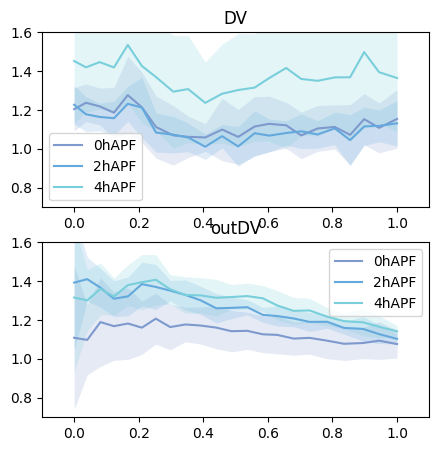

In [161]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_area"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



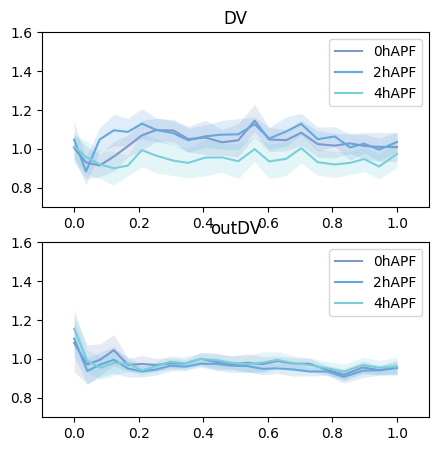

In [162]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_elongation"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



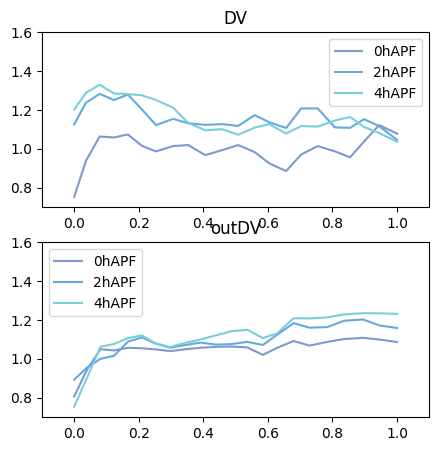

In [163]:
#plot lambda_area_mean vs cumcount_mean for each devstage_final
lambda_name = "lambda_rearrangement"
fig,axs = plt.subplots(2,1, figsize=(5,5))
regions = ["DV", "outDV"]
for i in range(len(regions)):
    region = regions[i]
    ax = axs[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,"devstage_init"]
        devstage_final = devstage_combinations.loc[j,"devstage_final"]

        df_temp = df_comparison[(df_comparison["region"] == region)&(df_comparison["devstage_init"] == devstage_init)&(df_comparison["devstage_final"] == devstage_final)]

        ax.plot(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"], label=devstage_final, color = color_dict[devstage_final])
        #ax.fill_between(df_temp["ref_pathlength_scaled"], df_temp[lambda_name + "_mean"]-df_temp[lambda_name + "_std"], df_temp[lambda_name + "_mean"]+df_temp[lambda_name + "_std"], alpha=0.2, color = color_dict[devstage_final], linewidth=0)
        #ax.fill_betweenx(df_stage["k_dist"], df_stage["k_dist_pathlength_mean"] - df_stage["k_dist_pathlength_std"], df_stage["k_dist_pathlength_mean"] + df_stage["k_dist_pathlength_std"], alpha=0.2, color = color_dict[devstages[j]])

    ax.set_title(region)
    ax.set_ylim(0.7,1.6)
    ax.set_xlim(-0.1,1.1)
    ax.legend()



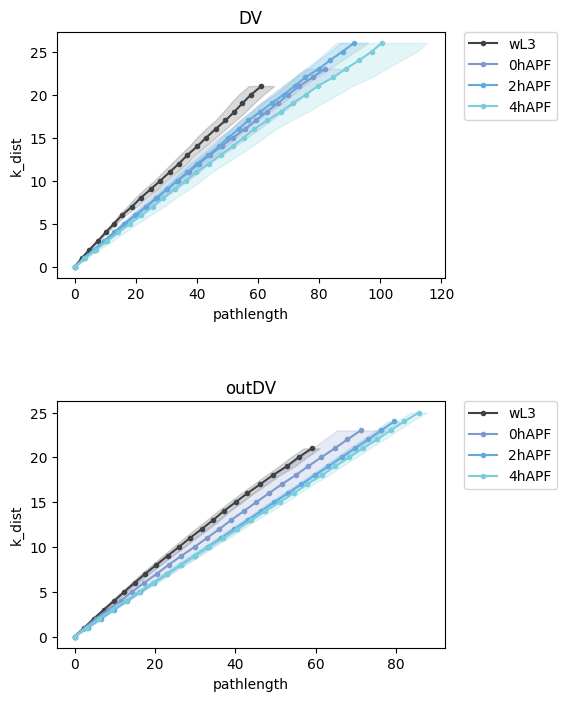

In [40]:
#plot k_dist vs cumcount for each devstage and each region

fig, axs = plt.subplots(2, 1, figsize=(5, 8))

regions = ["DV", "outDV"]
devstages = ["wL3", "0hAPF", "2hAPF", "4hAPF"]

for i in range(len(regions)):

    region = regions[i]
    ax = axs[i]

    for j in range(len(devstages)):

        df_stage = df_pool_devstage.query("region == @region and devstage == @devstages[@j]")

        #ax.plot(df_stage["cumcount_mean"], df_stage["k_dist"], label=devstages[j], marker="o", linestyle="-", color = color_dict[devstages[j]], markersize = 3) 
        ax.plot(df_stage["k_dist_pathlength_mean"], df_stage["k_dist"], label=devstages[j], marker="o", linestyle="-", color = color_dict[devstages[j]], markersize = 3) 
        #fill between y and x1 and x2
        ax.fill_betweenx(df_stage["k_dist"], df_stage["k_dist_pathlength_mean"] - df_stage["k_dist_pathlength_std"], df_stage["k_dist_pathlength_mean"] + df_stage["k_dist_pathlength_std"], alpha=0.2, color = color_dict[devstages[j]])

    #legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("pathlength")
    ax.set_ylabel("k_dist")
    ax.set_title(region)

    #ax.set_ylim([-1, 5.5])
    #ax.set_xlim([0, 55])

#give some space between subplots
plt.subplots_adjust(hspace = 0.5)

In [170]:
df_test = pd.DataFrame({'a': ['init', 'final','init', 'final'], 'region' : ['DV','DV','outDV', 'outDV'], 'offset': [0,10,20,200]})
df_test2 = pd.DataFrame({'a': ['init','init','final','init', 'final','final','init', ], 'b': [0,1,2,3,4,5,6], 'region':['DV','outDV','outDV','DV','DV','outDV','DV']})

df_merge = pd.merge(df_test2,df_test,  on=['a','region'])
df_merge

,a,b,region,offset
0,init,0,DV,0
1,init,3,DV,0
2,init,6,DV,0
3,init,1,outDV,20
4,final,2,outDV,200
5,final,5,outDV,200
6,final,4,DV,10


In [142]:
df_test[["diff_a_forward", "diff_a_backward"]].mean(axis = 1)

0    2.0
1    2.5
2    3.0
dtype: float64